In [112]:
import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()
import os
import shutil
import zipfile
import tarfile
import urllib
import requests
from tqdm import tqdm
import torch
from weaver.nn.model.ParticleTransformer import ParticleTransformer
from weaver.utils.logger import _logger
import torch.optim as optim
from EfficientParticleTransformer import EfficientParticleTransformer
import matplotlib.pyplot as plt


In [113]:
def build_features_and_labels(tree, transform_features=True):
    
    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label_*'])

    # compute new features
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])
    a['part_d0'] = np.tanh(a['part_d0val'])
    a['part_dz'] = np.tanh(a['part_dzval'])

    # apply standardization
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0
        a['part_d0err'] = _clip(a['part_d0err'], 0, 1)
        a['part_dzerr'] = _clip(a['part_dzerr'], 0, 1)

    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'], # not used in ParT
        'pf_features': [
            'part_pt_log', 
            'part_e_log',
            'part_logptrel',
            'part_logerel',
            'part_deltaR',
            'part_charge',
            'part_isChargedHadron',
            'part_isNeutralHadron',
            'part_isPhoton',
            'part_isElectron',
            'part_isMuon',
            'part_d0',
            'part_d0err',
            'part_dz',
            'part_dzerr',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']
    out['label'] = np.stack([a[n].to_numpy().astype('int') for n in label_list], axis=1)
    
    return out

In [114]:
def _clip(a, a_min, a_max):
    try:
        return np.clip(a, a_min, a_max)
    except ValueError:
        return ak.unflatten(np.clip(ak.flatten(a), a_min, a_max), ak.num(a))

In [115]:
def _pad(a, maxlen, value=0, dtype='float32'):
    if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
        return a
    elif isinstance(a, ak.Array):
        if a.ndim == 1:
            a = ak.unflatten(a, 1)
        a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
        return ak.values_astype(a, dtype)
    else:
        x = (np.ones((len(a), maxlen)) * value).astype(dtype)
        for idx, s in enumerate(a):
            if not len(s):
                continue
            trunc = s[:maxlen].astype(dtype)
            x[idx, :len(trunc)] = trunc
        return x


In [121]:
class EfficientParticleTransformerWrapper(torch.nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.mod = EfficientParticleTransformer(**kwargs)
        self.attention_matrix = None 
        self.interactionMatrix = None

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'mod.cls_token', }

    def forward(self, points, features, lorentz_vectors, mask):
        output = self.mod(features, v=lorentz_vectors, mask=mask)
        self.attention_matrix = self.mod.getAttention()
        self.interactionMatrix = self.mod.getInteraction()
        return output
    
    def get_attention_matrix(self):
        return self.attention_matrix
    def get_interactionMatrix(self):
        return self.interactionMatrix
    


def get_model(**kwargs):

    cfg = dict(
        input_dim=17,
        num_classes=10,
        # network configurations
        pair_input_dim=4, # 4,
        use_pre_activation_pair=False,
        embed_dims=[128, 512, 128],
        pair_embed_dims=[64,64,64],
        num_heads=8,
        num_layers=8,
        num_cls_layers=2,
        block_params=None,
        cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
        fc_params=[],
        activation='gelu',
        # misc
        trim=True,
        for_inference=False,
    )
    cfg.update(**kwargs)
    _logger.info('Model config: %s' % str(cfg))

    model = EfficientParticleTransformerWrapper(**cfg)

    model_info = {
      
    }

    return model, model_info


def get_loss(data_config, **kwargs):
    return torch.nn.CrossEntropyLoss()

In [122]:
model, modInf = get_model()

2025-03-13 02:17:57 | INFO | weaver | Model config: {'input_dim': 17, 'num_classes': 10, 'pair_input_dim': 4, 'use_pre_activation_pair': False, 'embed_dims': [128, 512, 128], 'pair_embed_dims': [64, 64, 64], 'num_heads': 8, 'num_layers': 8, 'num_cls_layers': 2, 'block_params': None, 'cls_block_params': {'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0}, 'fc_params': [], 'activation': 'gelu', 'trim': True, 'for_inference': False}
2025-03-13 02:17:57 | INFO | weaver | cfg_block: {'embed_dim': 128, 'num_heads': 8, 'ffn_ratio': 4, 'dropout': 0.1, 'attn_dropout': 0.1, 'activation_dropout': 0.1, 'add_bias_kv': False, 'activation': 'gelu', 'scale_fc': True, 'scale_attn': True, 'scale_heads': True, 'scale_resids': True}
2025-03-13 02:17:57 | INFO | weaver | cfg_cls_block: {'embed_dim': 128, 'num_heads': 8, 'ffn_ratio': 4, 'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0, 'add_bias_kv': False, 'activation': 'gelu', 'scale_fc': True, 'scale_attn': True, 'scale_heads': True, 'scal

In [123]:
state_dict = torch.load('/Users/anrunw/Downloads/net_best_epoch_state.pt', map_location=torch.device('cpu'))

/var/folders/zj/988sh2h5501gdntnynlhn0480000gn/T/ipykernel_38961/468357821.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/Users/anrunw/Downloa

In [ ]:
state_dict['']

In [130]:
state_dict['mod.blocks.0.attn.compress_k.weight']

tensor([[ 0.0868,  0.1044,  0.1065,  ..., -0.2364, -0.1388, -0.1922],
        [ 0.5321,  0.5101,  0.4686,  ..., -0.1891, -0.1792, -0.2925],
        [ 0.3197,  0.3207,  0.3080,  ..., -0.3426, -0.3938, -0.3101],
        ...,
        [-0.2922, -0.2669, -0.2432,  ..., -0.3830, -0.3150, -0.4072],
        [ 0.1279,  0.1165,  0.1238,  ..., -0.2586, -0.2175, -0.1878],
        [ 0.0576,  0.0638,  0.0337,  ..., -0.2572, -0.2480, -0.3329]])

In [132]:
state_dict['mod.blocks.0.attn.compress_k.weight'].shape

torch.Size([16, 128])

In [133]:
state_dict['mod.blocks.0.attn.out_proj.weight'].shape

torch.Size([128, 128])

In [134]:
state_dict['mod.blocks.0.attn.compress_k.weight'][0,:].shape

torch.Size([128])

In [153]:
summed.shape

(128,)

In [155]:
summed.shape

(128,)

In [159]:
x = np.arange(128)

In [160]:
x

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127])

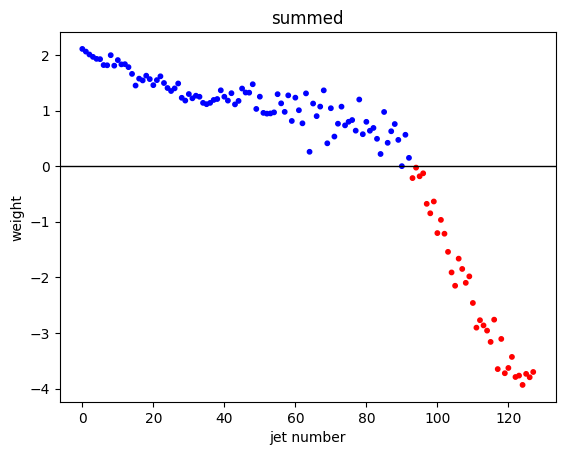

In [175]:
plt.figure()
summed = np.sum(np.array(state_dict['mod.blocks.0.attn.compress_k.weight']), axis=0)
x = range(128)
y = summed

colors = ['red' if val < 0 else 'blue' for val in y]

plt.scatter(x, y, c=colors, s=10)
plt.axhline(y=0, color='black', linewidth=1)
plt.ylabel('weight')
plt.xlabel('jet number')
plt.title('summed')
plt.show()

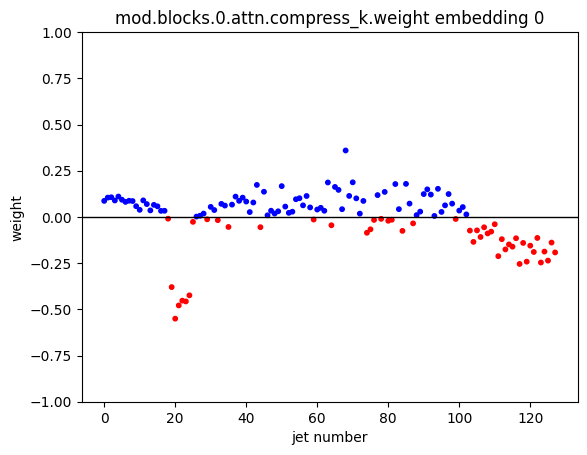

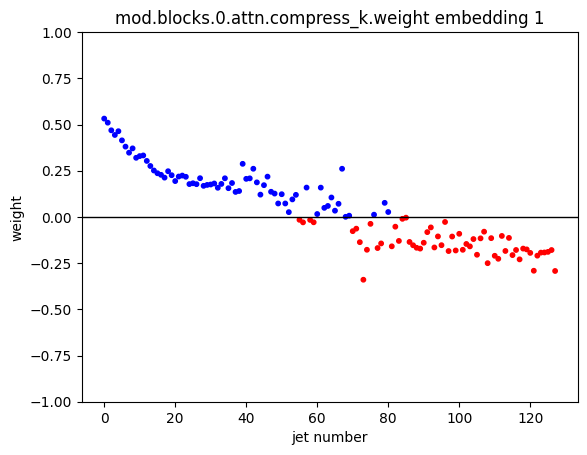

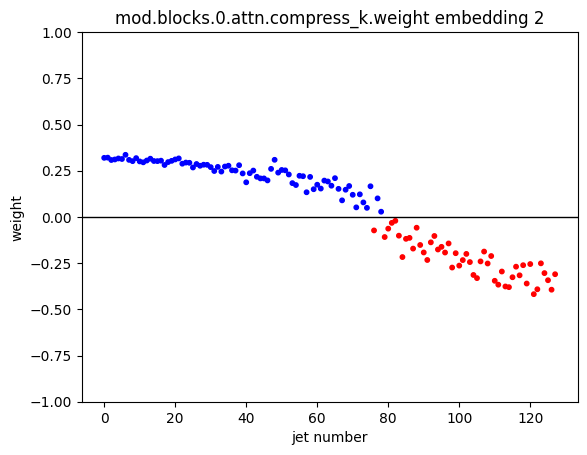

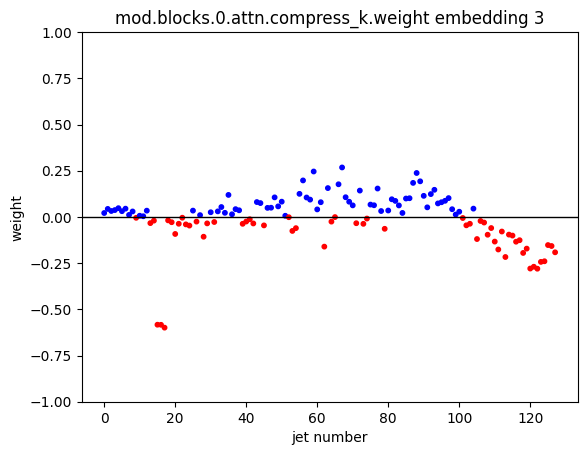

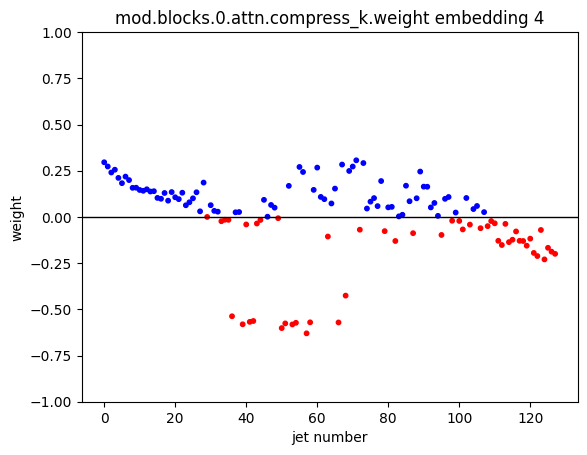

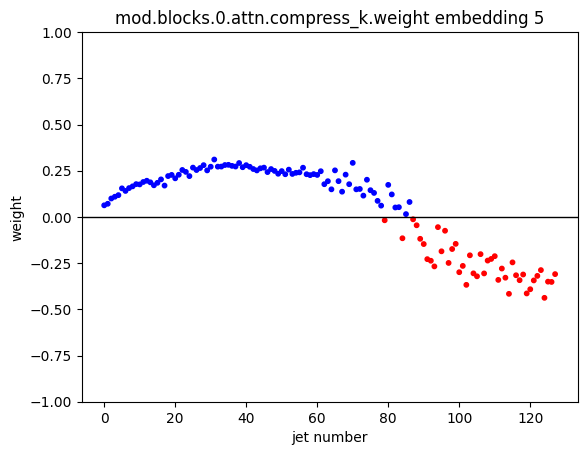

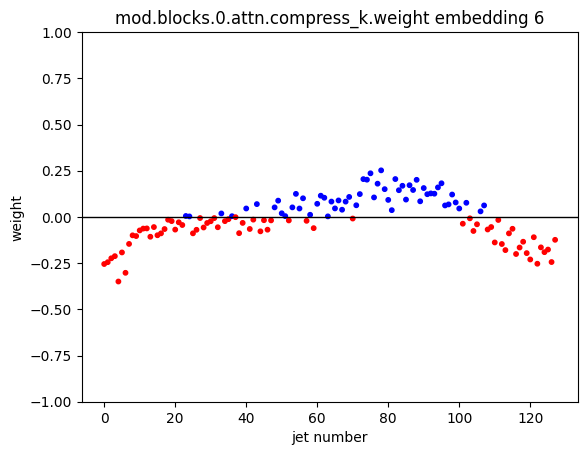

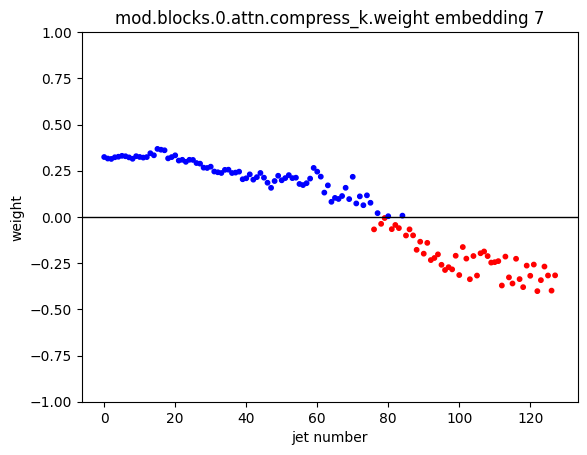

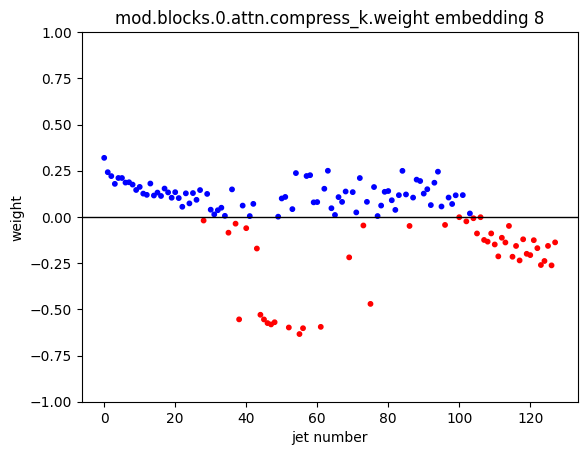

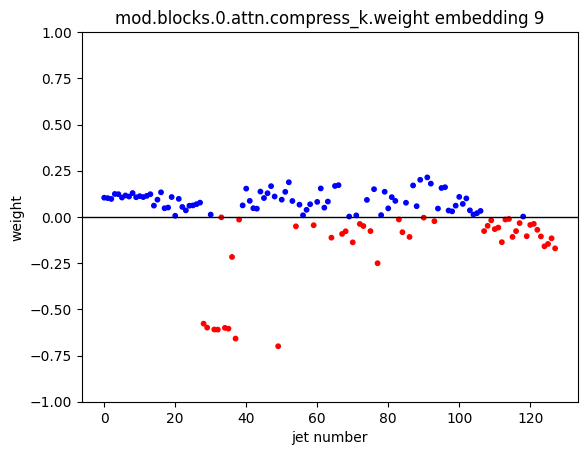

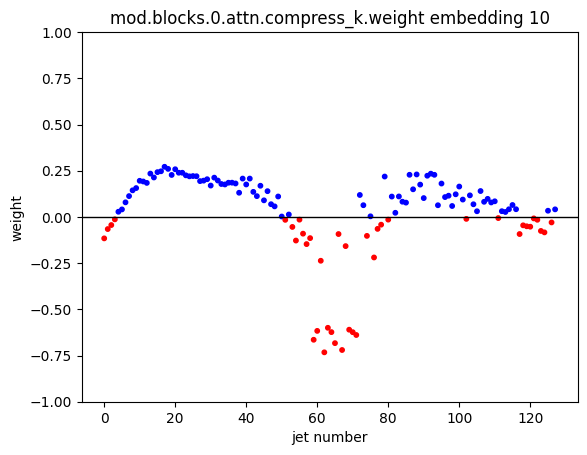

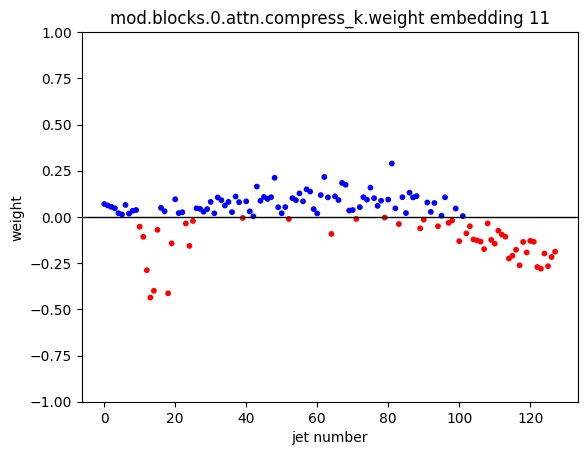

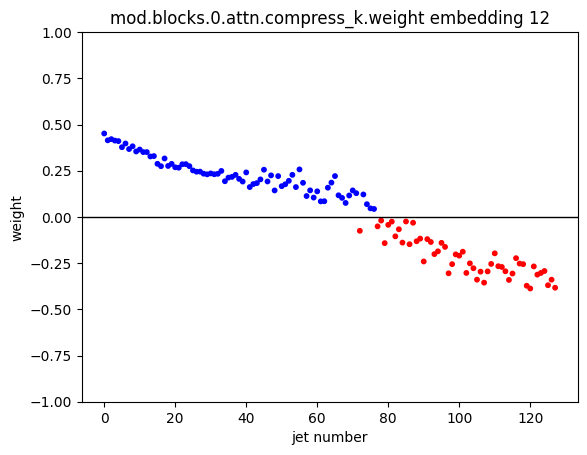

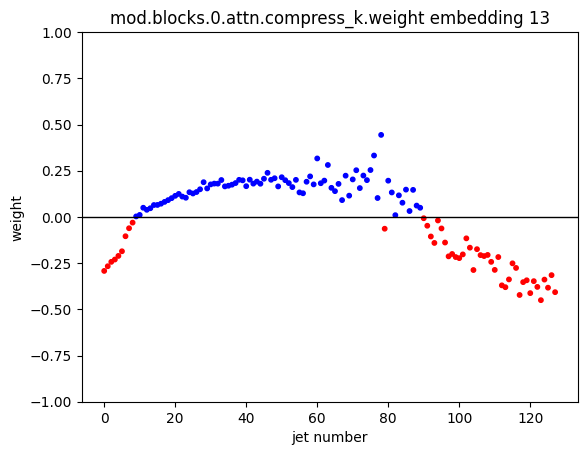

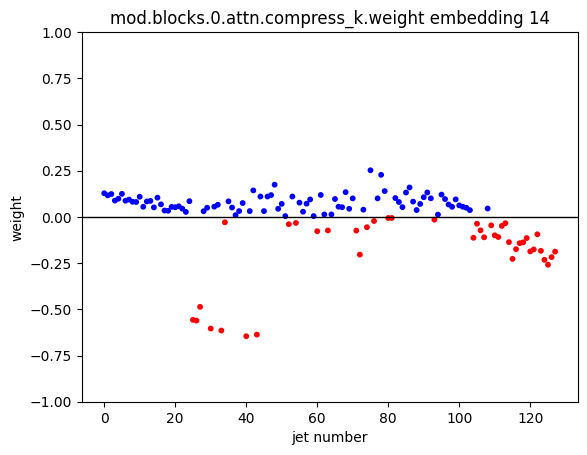

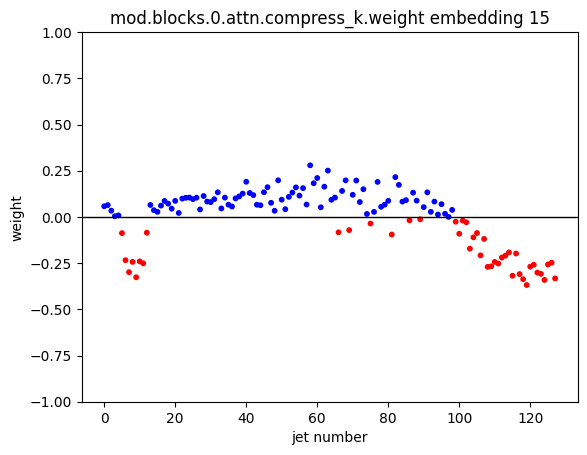

In [182]:
import matplotlib.pyplot as plt

for num in range(16):
    plt.figure()
    x = range(128)
    compressLayer = 'mod.blocks.0.attn.compress_k.weight'
    y = state_dict[compressLayer][num, :]
    
    colors = ['red' if val < 0 else 'blue' for val in y]
    
    plt.scatter(x, y, c=colors, s=10)
    plt.ylim(-1,1)
    plt.axhline(y=0, color='black', linewidth=1)
    plt.ylabel('weight')
    plt.xlabel('jet number')
    plt.title(str(compressLayer) + ' embedding ' + str(num))
    plt.show()


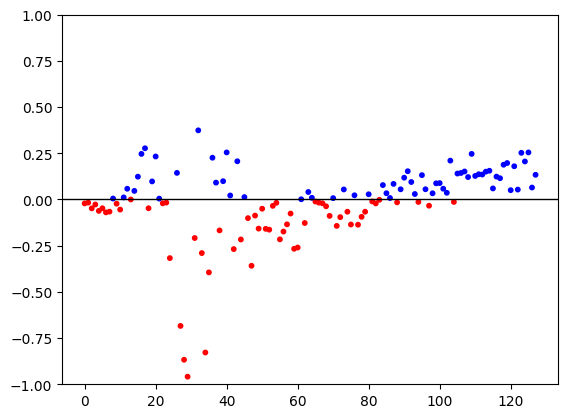

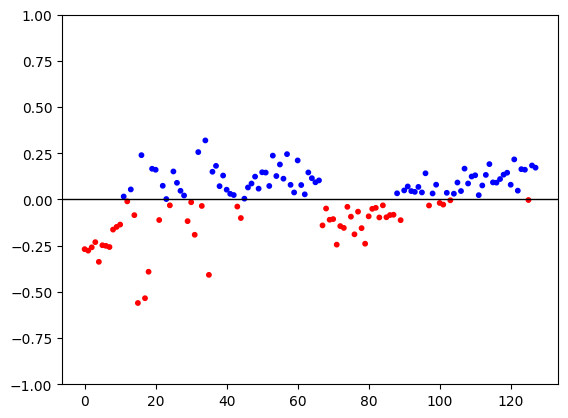

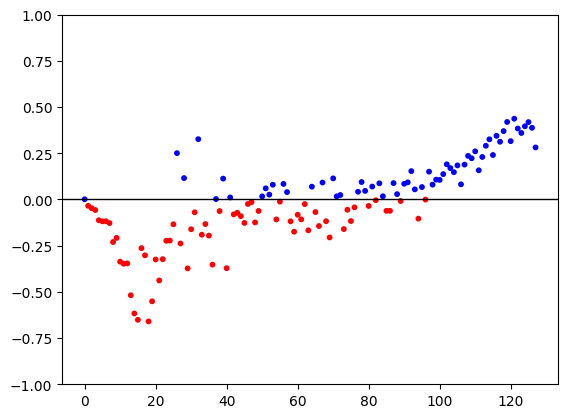

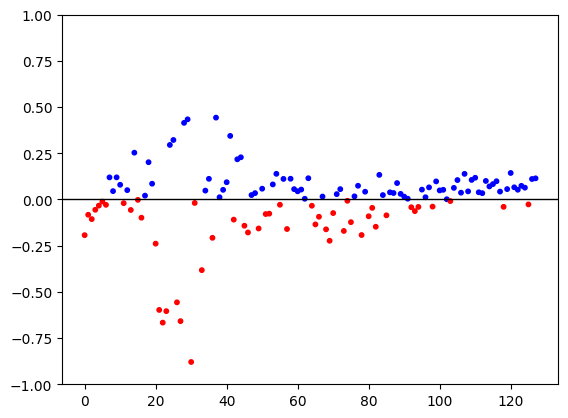

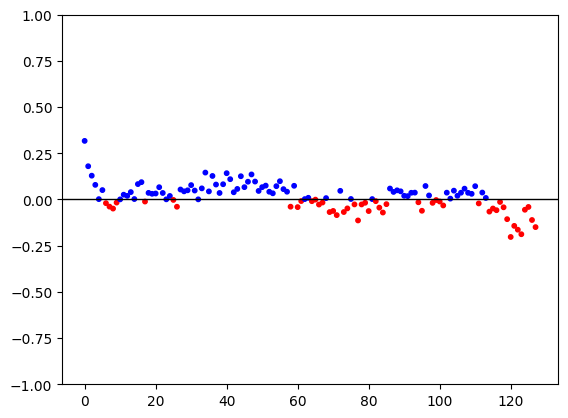

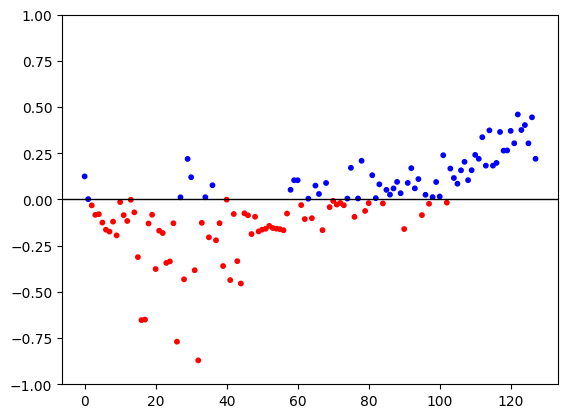

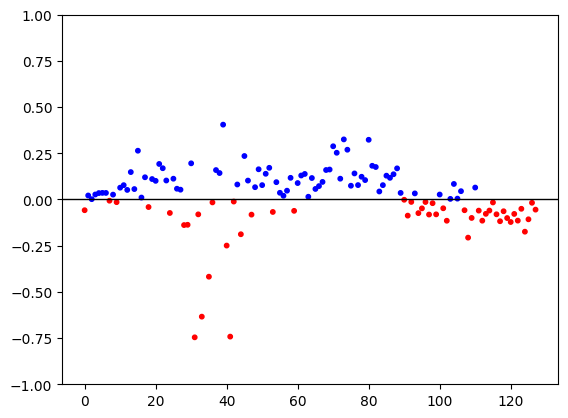

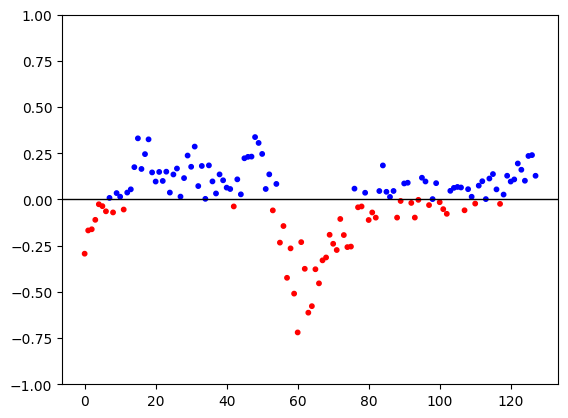

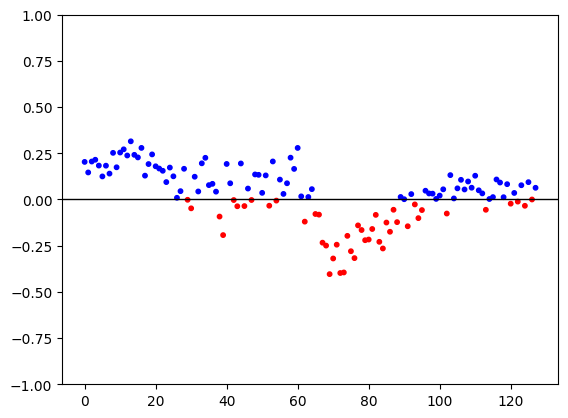

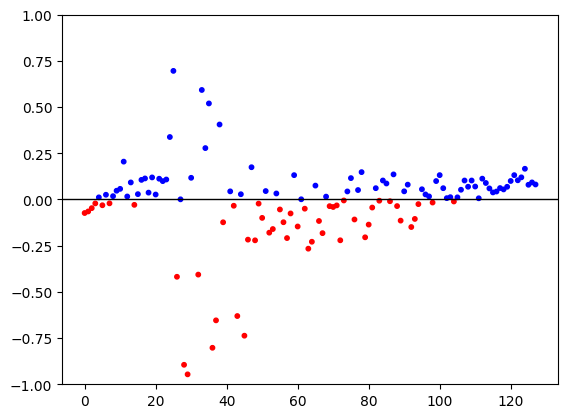

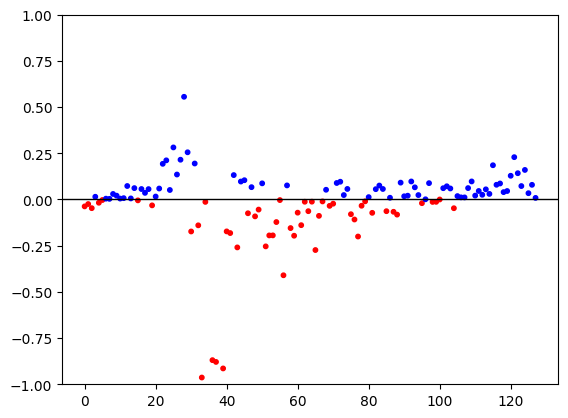

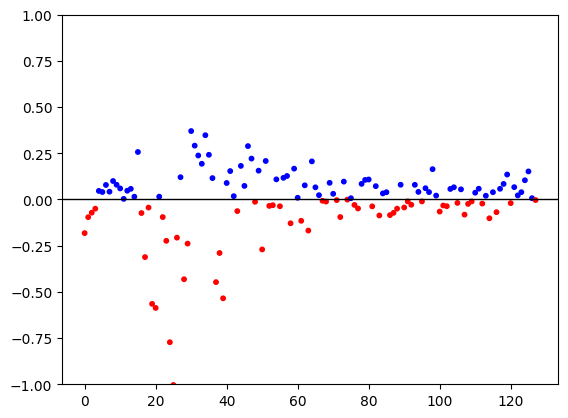

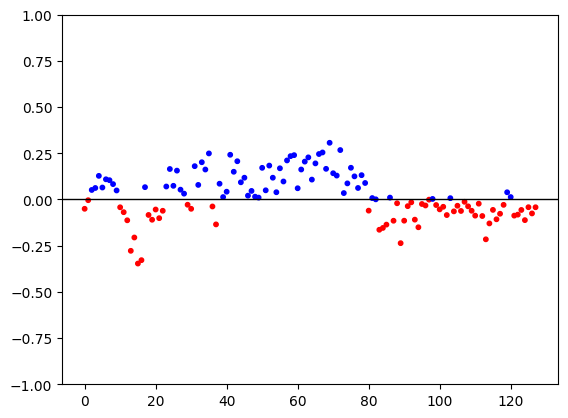

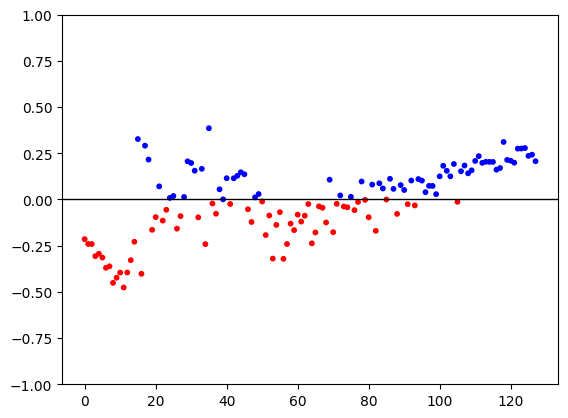

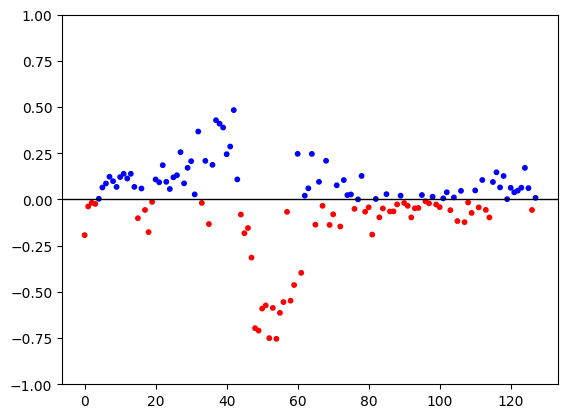

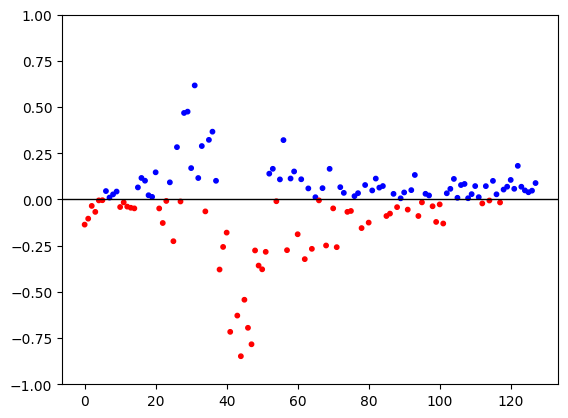

In [184]:
import matplotlib.pyplot as plt

for num in range(16):
    plt.figure()
    # Get x values (0 to 127) and y values for the current row
    x = range(128)
    y = state_dict['mod.blocks.4.attn.compress_k.weight'][num, :]
    
    # Assign colors based on y value: red if below 0, blue if 0 or above
    colors = ['red' if val < 0 else 'blue' for val in y]
    
    # Create scatter plot with color coding
    plt.scatter(x, y, c=colors, s=10)
    plt.ylim(-1,1)
    # Draw a horizontal line at y = 0
    plt.axhline(y=0, color='black', linewidth=1)
    
    plt.show()


In [31]:
np.mean(np.array(state_dict['mod.blocks.0.attn.q_proj.weight']), axis=1)

array([ 0.00267407,  0.01784276,  0.01193712,  0.00504693, -0.02696053,
        0.01115262, -0.02146708, -0.01292483, -0.00609136, -0.02672097,
        0.00747515, -0.01436312, -0.0196795 , -0.01779279, -0.01375688,
        0.0206435 ,  0.00278336, -0.01390425,  0.00892142, -0.00076343,
        0.00294535,  0.01989678, -0.01254028, -0.01077057, -0.00482541,
       -0.02251148,  0.00188701, -0.0195853 ,  0.02059586,  0.01520078,
       -0.00142531,  0.01396998, -0.00321694,  0.00208072, -0.01569529,
       -0.01161239, -0.0183768 ,  0.03854949,  0.00276449,  0.00464816,
       -0.02428554, -0.00538074, -0.00495368,  0.03562447,  0.01777412,
       -0.02521778,  0.00726921, -0.00110031,  0.01044671, -0.07772803,
       -0.03235867, -0.00639518,  0.03057482,  0.00444357, -0.0021539 ,
        0.00780446,  0.0167983 , -0.02594207, -0.02646081, -0.0260948 ,
       -0.00591265, -0.00462988, -0.04505343, -0.0212969 , -0.02710151,
       -0.0029367 , -0.00403254, -0.00601416,  0.00279398,  0.01